In [1]:
import numpy as np
import glob
import datetime
from pmap import getmap
import pandas
import os
import lxml.etree as et
from netCDF4 import Dataset
import sys

In [2]:
%matplotlib notebook

## Read tide gauges data

In [3]:
OFILE='/mnt/pandora/Projects_Critech/EX_2015_CoastAlRisk/maps/data/s_b_data.txt'

In [4]:
obs=pandas.read_csv(OFILE,delimiter='\t')

In [5]:
obs

,ID,NAME,latobs,lonobs,latcalc,loncalc
0,1630,Almeira,36.8300,-2.4800,36.72506,-2.468386
1,1706,Valencia,39.4400,-0.3100,39.44040,-0.299000
2,819,Barcelona,41.3400,2.1600,41.27749,2.213909
3,1461,Palma de Mallorca,39.5600,2.6380,39.39457,2.614552
4,1741,Sete,43.3976,3.6991,43.31857,3.761195
5,1500,Corsica,42.9670,9.3500,43.09528,9.267036
6,1841,Carloforte,39.1480,8.3095,39.22599,8.231240
7,1848,Imperia,43.8783,8.0189,43.83057,8.149480
8,1846,Genova,44.4101,8.9255,44.32259,8.919400
9,1843,Civitavecchia,42.0940,11.7896,41.99920,11.677270


## Read HyFlux data

In [6]:
# define year
Y=2015

In [7]:
PATH='/mnt/ECMWF/processed/{}/FIX_MED_SEA/'.format(Y)  # ECMWF

### read bathymetry of first folder to define grid

In [8]:
folders=glob.glob(PATH+'calc_*')

In [9]:
filename=folders[0]+'/bathymetry.tif'
grid = getmap(filename)

gt=grid.GeoTr

width=grid.NCOLS
height=grid.NROWS

minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5]
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3]

lon=np.linspace(minx,maxx,width,endpoint=True)
lat=np.linspace(miny,maxy,height,endpoint=True)


### define start time of runs

In [10]:
odate=datetime.datetime.strptime(folders[0][-11:],'%Y%m%d.%H')
print odate

2015-01-01 00:00:00


We can check the restart date by parsing the locations.xml file ...

In [11]:
folders[0]+'/locations.xml'

'/mnt/ECMWF/processed/2015/FIX_MED_SEA/calc_20150101.00/locations.xml'

In [12]:
tree0=et.ElementTree(file=folders[0]+'/locations.xml')
for elem in list(tree0.getiterator()):
    if elem.tag == 'pubDate':
                 tinit=datetime.datetime.strptime(elem.text,'%d %b %Y %H:%M')
                 break
tinit

datetime.datetime(2015, 1, 1, 0, 0)

In [13]:
#SELECT POINT from database above
point=14

In [14]:
plat,plon=obs['latcalc'][point],obs['loncalc'][point]

In [15]:
i=np.abs(lat-plat).argmin()
j=np.abs(lon-plon).argmin()


In [16]:
print i,j

216 292


In [17]:
obs['ID'][point]

1866

### specify dates 

In [18]:
t0='20150101.00'

In [19]:
t1='20151231.12'

In [20]:
tstart=datetime.datetime.strptime(t0,'%Y%m%d.%H')
tend=datetime.datetime.strptime(t1,'%Y%m%d.%H')


In [21]:
dt=(tend-tstart).total_seconds()
ndt=dt/(3600*12)
ndt=np.int(ndt)+1


## read from netCDF files

In [22]:
combined=[] # store time and height
tw=[]
tstamp = [] # for use later

In [23]:
for it in range(ndt):
    idate=tstart+datetime.timedelta(hours=12*it)
    dstamp=datetime.datetime.strftime(idate,'%Y%m%d.%H')
    
    # track completion
    sys.stdout.write('\r')
    sys.stdout.write(dstamp)
    sys.stdout.flush() 

    try:
        tree0=et.ElementTree(file=PATH+'calc_{}/locations.xml'.format(dstamp))
        for elem in list(tree0.getiterator()):
            if elem.tag == 'pubDate':
                tn=datetime.datetime.strptime(elem.text,'%d %b %Y %H:%M')
                break
        if tn != tinit :
            sys.stdout.write( '  > restart date : {}'.format(tn)) # new restart day
            tinit=tn
        
    except:
        sys.stdout.write('  > problem with locations.xml file')
        pass


    try:

        filename=PATH+'calc_{}/NETCDF_H.nc'.format(dstamp)
        d =  Dataset(filename)
        ha=d.variables['HA'][:,i,j] # the prior 6 hours + 12 hours forecasting
        t=d.variables['TIME'][:]
        
        tp=[]
        for ts in t:
            if t[0] == 0 :
                tp.append(idate+datetime.timedelta(seconds=ts))
                tinit=idate
            else:
                tp.append(tinit+datetime.timedelta(seconds=ts))
                       
        iw1=np.argwhere(np.array(tp)==idate).flatten()[0]
        
        tmax=(t[-1]-t[iw1])/3600.

        iw2=np.argwhere(np.array(tp)==idate+datetime.timedelta(hours=tmax)).flatten()[0]
        tw.append(tp[iw1:iw2+1])
        combined.append(ha[iw1:iw2+1])
        tstamp.append(dstamp)

    except Exception as e:
        sys.stdout.write('  > {}'.format(e))
        sys.stdout.write('  > problem with netcdf file, skiping'.format(dstamp))
        sys.stdout.write('\n')





20150422.00  > problem with locations.xml file  > No such file or directory  > problem with netcdf file, skiping
20150422.12  > problem with locations.xml file  > No such file or directory  > problem with netcdf file, skiping
20150424.00  > index 0 is out of bounds for axis 0 with size 0  > problem with netcdf file, skiping
20150425.12  > index 0 is out of bounds for axis 0 with size 0  > problem with netcdf file, skiping
20150426.12  > index 0 is out of bounds for axis 0 with size 0  > problem with netcdf file, skiping
20150427.00  > problem with locations.xml file  > No such file or directory  > problem with netcdf file, skiping
20150427.12  > index 0 is out of bounds for axis 0 with size 0  > problem with netcdf file, skiping
20150625.12  > problem with locations.xml file  > No such file or directory  > problem with netcdf file, skiping
20150626.00  > problem with locations.xml file  > No such file or directory  > problem with netcdf file, skiping
20150626.12  > problem with locatio

In [24]:
#Create the MultiIndex
rt=[]
k=0
for ida in tstamp:
    g=np.size(tw[k])*[ida]
    rt=np.append(rt,g)
    k += 1

In [25]:
index=[np.array(rt).ravel(),[item for sublist in tw for item in sublist]]

In [26]:
pIndex=pandas.MultiIndex.from_arrays(index,names=['run date','time'])

In [27]:
data=[item for sublist in combined for item in sublist] # unravel list

In [28]:
res=pandas.DataFrame(data,index=pIndex,columns=['h - netCDF'])

<IPython.core.display.Javascript object>


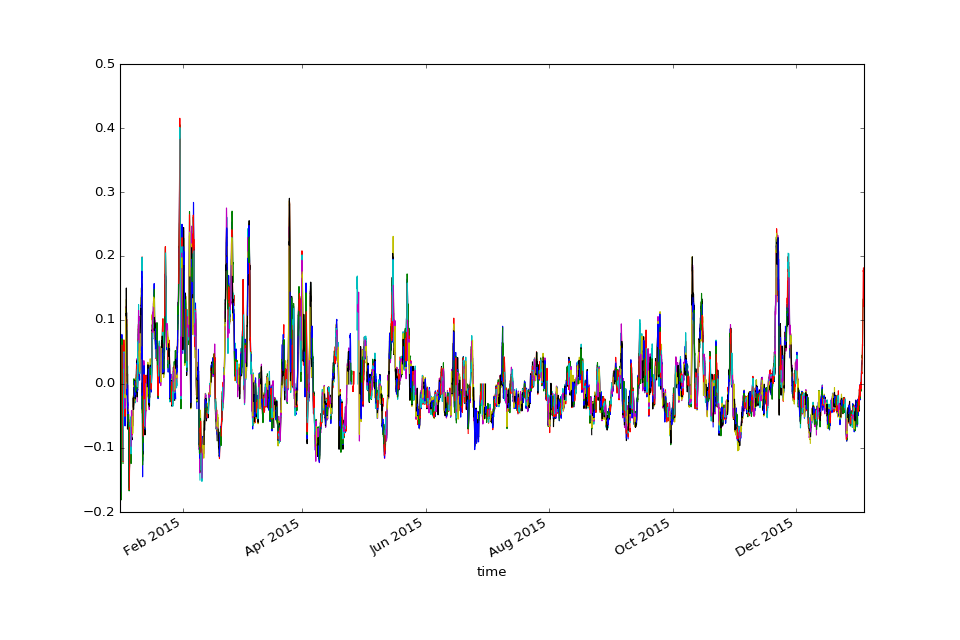

In [29]:
#plot
ax=res.unstack(level=0).plot(figsize=(12,8),legend=False)

### Reading from tif files

In [30]:
combined=[] # store time and height
tw=[]
tstamp = [] # for use later

In [31]:
for it in range(ndt):
    idate=tstart+datetime.timedelta(hours=12*it)
    dstamp=datetime.datetime.strftime(idate,'%Y%m%d.%H')
    
    # track completion
    sys.stdout.write('\r')
    sys.stdout.write(dstamp)
    sys.stdout.flush() 

    try:
        tree0=et.ElementTree(file=PATH+'calc_{}/locations.xml'.format(dstamp))
        for elem in list(tree0.getiterator()):
            if elem.tag == 'pubDate':
                tn=datetime.datetime.strptime(elem.text,'%d %b %Y %H:%M')
                break
        if tn != tinit :
            sys.stdout.write( '  > restart date : {}'.format(tn)) # new restart day
            tinit=tn
        
    except:
        sys.stdout.write('  > problem with locations.xml file')
        pass


    try:
        hfiles=glob.glob(PATH+'calc_{}/TIF_H*.tif'.format(dstamp))

        t=[np.int(l.split('_')[-1].split('.')[0]) for l in hfiles]
        
        
        # choose the files from the first 12 hours
        tp=[]
        for ts in t:
            if t[0] == 0 :
                tp.append(idate+datetime.timedelta(seconds=ts))
                tinit=idate
            else:
                tp.append(tinit+datetime.timedelta(seconds=ts))
                       
        iw1=np.argwhere(np.array(tp)==idate).flatten()[0]
        
        tmax=(t[-1]-t[iw1])/3600.  # compute all values after the current run timestamp

        iw2=np.argwhere(np.array(tp)==idate+datetime.timedelta(hours=tmax)).flatten()[0]
        tw.append(tp[iw1:iw2+1])
                
        
        for ifile in hfiles[iw1:iw2+1]:  
            dat=getmap(ifile)
            combined.append(np.flipud(dat.data)[i,j])
        
        tstamp.append(dstamp)

    except Exception as e:
        print e
        sys.stdout.write('  > problem with TIF files, skiping'.format(dstamp))
        sys.stdout.write('\n')





20150422.00  > problem with locations.xml fileindex 0 is out of bounds for axis 0 with size 0
  > problem with TIF files, skiping
20150427.12index 0 is out of bounds for axis 0 with size 0
  > problem with TIF files, skiping
20150625.12  > problem with locations.xml fileindex 0 is out of bounds for axis 0 with size 0
  > problem with TIF files, skiping
20150626.00  > problem with locations.xml fileindex 0 is out of bounds for axis 0 with size 0
  > problem with TIF files, skiping
20150626.12  > problem with locations.xml fileindex 0 is out of bounds for axis 0 with size 0
  > problem with TIF files, skiping
20150707.12  > problem with locations.xml fileindex 0 is out of bounds for axis 0 with size 0
  > problem with TIF files, skiping
20151231.12

In [32]:
#Create the MultiIndex
rt=[]
k=0
for ida in tstamp:
    g=np.size(tw[k])*[ida]
    rt=np.append(rt,g)
    k += 1

In [33]:
index=[np.array(rt).ravel(),[item for sublist in tw for item in sublist]]

In [34]:
pIndex=pandas.MultiIndex.from_arrays(index,names=['run date','time'])

In [35]:
res1=pandas.DataFrame(np.array(combined).ravel(),index=pIndex,columns=['h - TIFF'])

<IPython.core.display.Javascript object>


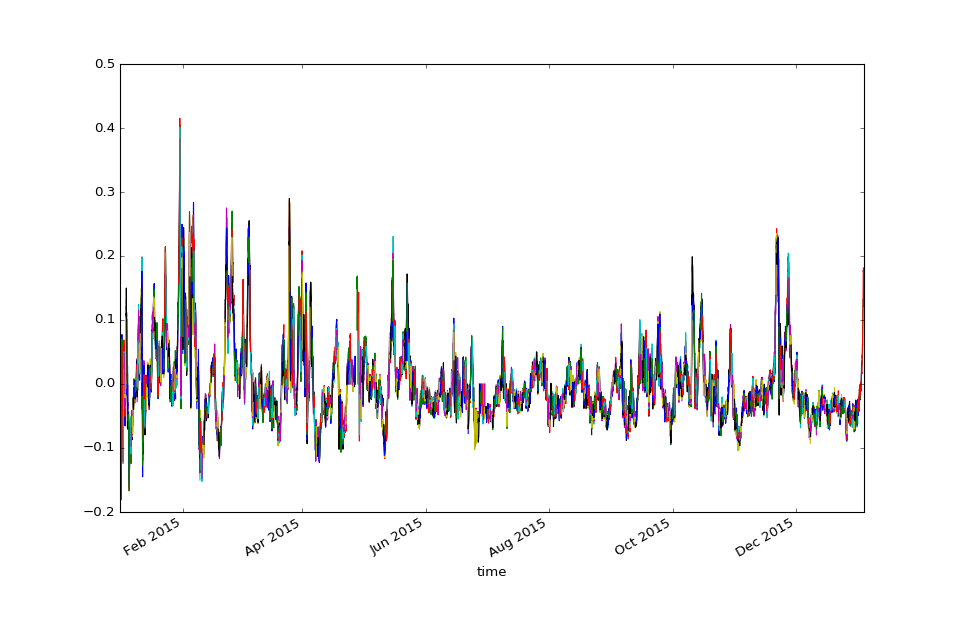

In [36]:
#plot
ax1=res1.unstack(level=0).plot(figsize=(12,8),legend=False)

<IPython.core.display.Javascript object>


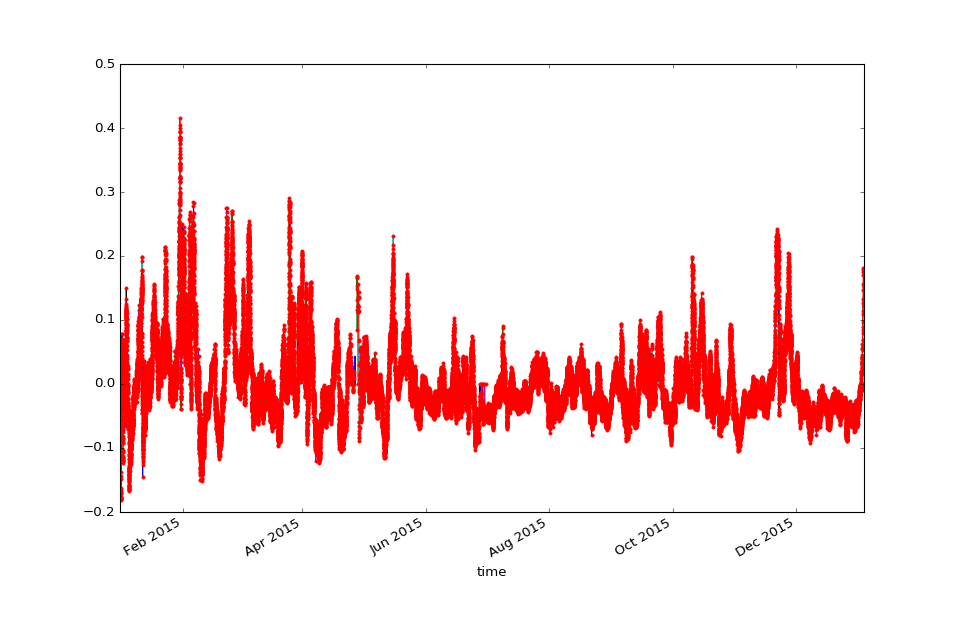

In [37]:
#plot both
ax1 = res1.unstack(level=0).plot(figsize=(12,8),legend=False)
res.unstack(level=0).plot(ax=ax1,color='red', linestyle='', marker='.',legend=False)

## SAVE DATA in CSV

In [38]:
SAVEPATH='tmp/'#/mnt/pandora/Users_Critech/Thomas/HYFLUX/'

In [39]:
res1.to_csv(SAVEPATH+obs['NAME'][point].strip()+'.csv', header=None)

### useful tidbits

In [40]:
res1[:5]


h - TIFF
run date    time                         
20150101.00 2015-01-01 00:00:00  0.000000
            2015-01-01 01:00:00 -0.007230
            2015-01-01 02:00:00 -0.021890
            2015-01-01 03:00:00 -0.028926
            2015-01-01 04:00:00 -0.056309

In [41]:
res1.xs('20150102.00') # single day

,h - TIFF
time,
2015-01-02 00:00:00,0.060493
2015-01-02 01:00:00,0.045998
2015-01-02 02:00:00,0.032793
2015-01-02 03:00:00,0.008875
2015-01-02 04:00:00,0.003418
2015-01-02 05:00:00,-0.013494
2015-01-02 06:00:00,-0.036314
2015-01-02 07:00:00,-0.055121
2015-01-02 08:00:00,-0.081242


In [42]:
res1.ix[('20150102.00','2015-01-02 21:00:00'):('20150102.00','2015-01-02 23:00:00')] # slice of a day

h - TIFF
run date    time                         
20150102.00 2015-01-02 21:00:00  0.058633
            2015-01-02 22:00:00  0.068916
            2015-01-02 23:00:00  0.061766

In [43]:
# for a time stamp and all days
res1.xs('2015-01-02 21:00:00', level=1)

,h - TIFF
run date,
20150101.00,0.053957
20150102.00,0.058633
20150102.12,0.033777
